In [1]:
%load_ext autoreload
%autoreload 1

%aimport utils
import pandas as pd
import numpy as np
import pickle
import os
from IPython.display import display, HTML
import matplotlib.pyplot as plt
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# The location to cache the feature, labels, and label names
# {
#     'X': features,
#     'Y': labels,
#     'Y_Names': label_names
# }
CACHE_LOCATION = os.path.join(os.getcwd(), 'cache')
PLOT_LOCATION = os.path.abspath(
    os.path.join(os.getcwd(), '..', 'Plots', 'ML_Features'))

## Building Optimal Indicators and Portfolios

In [3]:
def setup_indicators(country, storage):
    """
    Build best indicatros given a country name
    """
    aqr = utils.load_aqr_data(country).dropna()
    portfolios = utils.build_portfolio(aqr, main_weights=[0.7],
                                       prefix_names=['main'])
    rf = aqr['RF'].dropna()
    mkt = aqr['MKT'].dropna()
    po = utils.PortfolioOptimizer(portfolios=portfolios,
                                  riskfree=rf,
                                  market=mkt,
                                  country=country)

    po.get_stats_table(metric=metric)
    po.get_best_indicators()
    po.get_best_returns()
    
    storage[country] = po


countries = ['USA', 'Europe', 'JPN']
metric = 'sharpe'
po_dict = {}

for country in countries:
    display(HTML('<p>Building Indicators for <span style="color:red">[%s]</span>...</p>' % country))
    setup_indicators(country, po_dict)
print('Finished')

Finished


## Build Features / Labels Set

Use a set of macro factors and the labels picked as the optimal weighted strategy over months

> **Note** This section might change due to several features are still under constructions

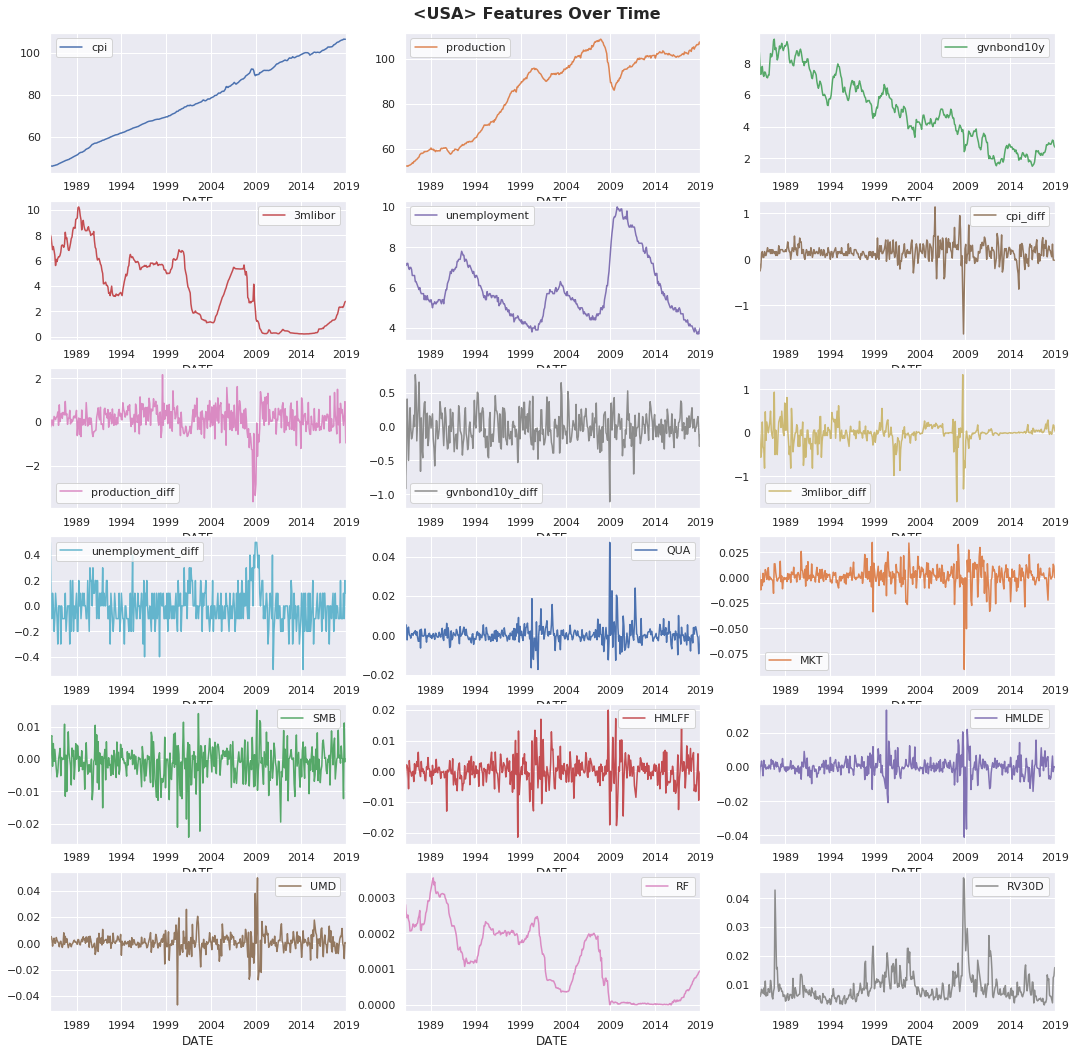

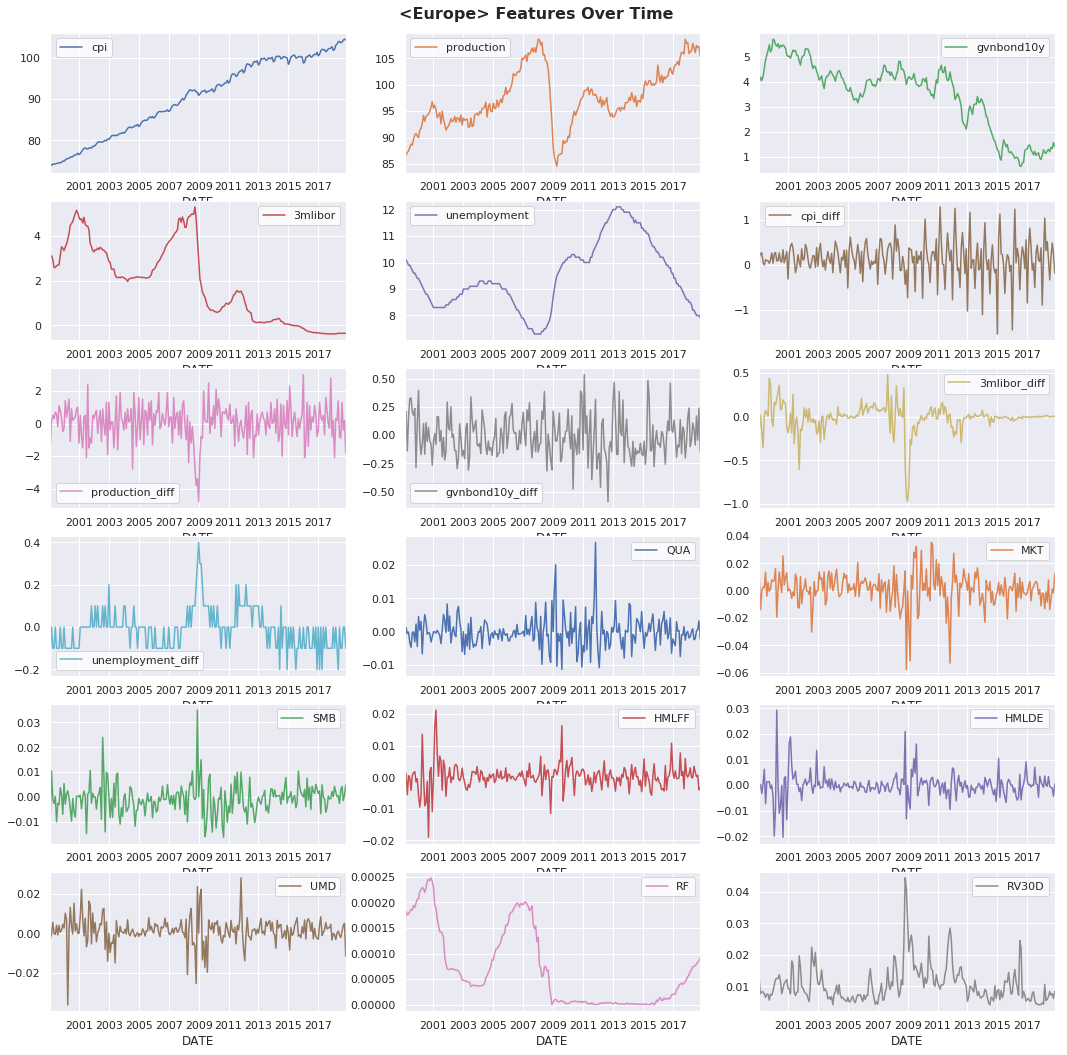

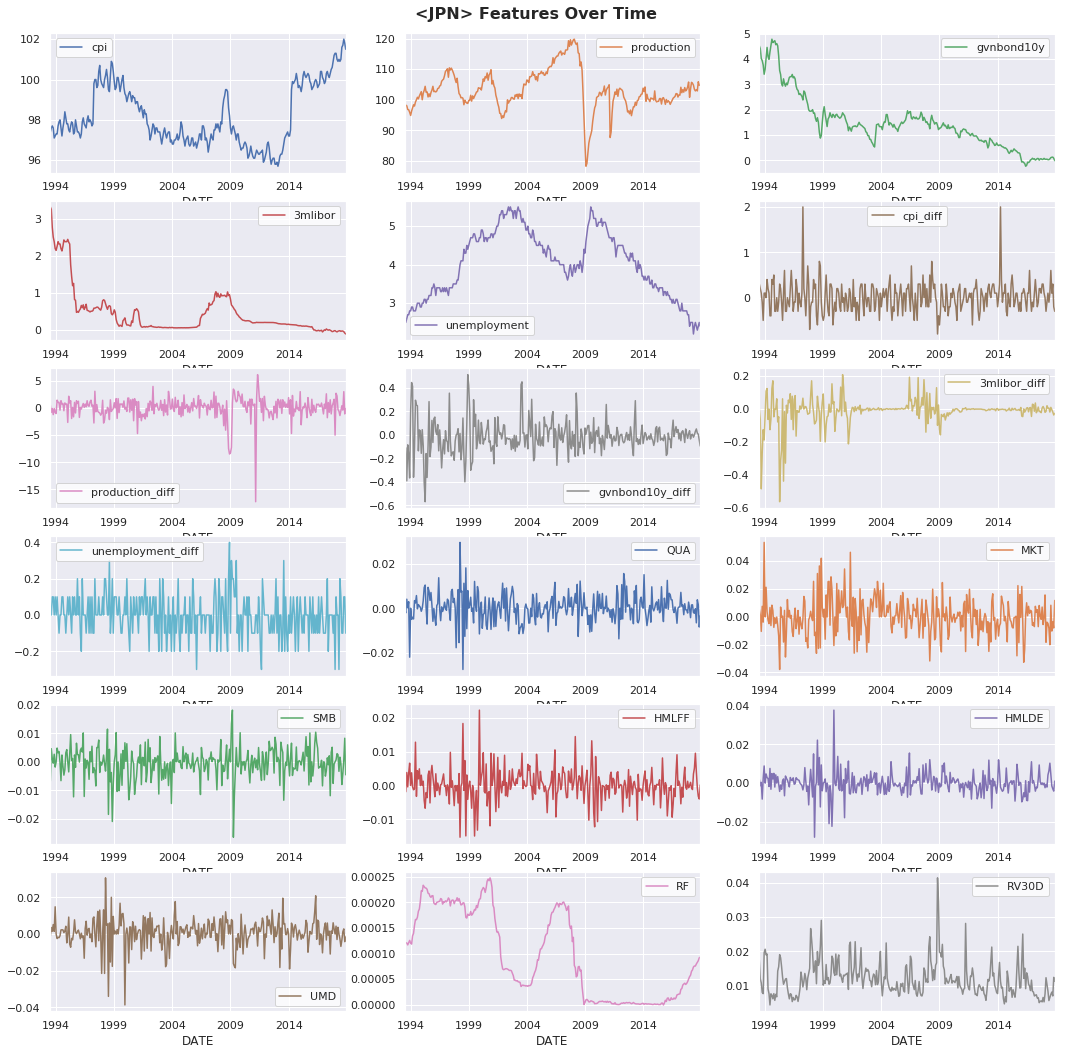

In [4]:
for country in countries:
    display(HTML('<p>Building Feature/Labels for <span style="color:red">[%s]</span>...</p>' % country))
    features = utils.FeatureBuilder(country).get_features()
    labels, label_names = po_dict[country].get_labels()
    feature_and_labels = pd.merge(features, labels, left_index=True,
                                  right_index=True, how='inner')
    res = {
        'X': feature_and_labels.iloc[:, :-1],
        'Y': feature_and_labels[['labels']],
        'Y_Names': label_names
    }
    
    # Dump results into cache, will be used in the modeling notebook
    with open(os.path.join(CACHE_LOCATION, '%s.pickle' % country), 'wb') as f:
        pickle.dump(res, f)
    
    # Plot the features
    fp = features.plot(subplots=True, layout=(-1, 3), figsize=(18, 18), sharex=False)
    fig = fp[0, 0].get_figure()
    fig.suptitle('<%s> Features Over Time' % country, fontsize=16,
                 fontweight=700, y=0.9)
    plt.show()
    fig.savefig(os.path.join(PLOT_LOCATION, '%s_simple_features.pdf' % country), bbox_inches='tight')

    display(HTML('<hr>'))